In [1]:
#from IPython.display import IFrame
import json
import requests
import numpy as np
from scipy.stats import kde
from shapely.geometry import  MultiLineString, Polygon, Point
#import geojson as gj
from shapely import wkt

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gs
import mplleaflet
from tqdm import tqdm

In [15]:
base = '/Users/karlen/Work/Insight/data/raw/'

fcolli_tims = base + 'collisions/tims_collisions.csv'
fpavcond = base+'pavement_cond.csv'
ftraffic = base+'traffic_volume/csv/AADT{}.csv'

fcrime = base+'crime/Crime_Data_from_2010_to_Present.csv'

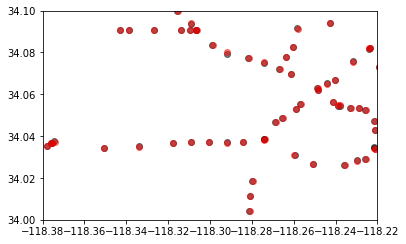

In [12]:
crs = {'init': 'epsg:4326'}
df_aadt1 = pd.read_csv(ftraffic.format(2015))
df_aadt2 = pd.read_csv(ftraffic.format(2015))
df_aadt1['GEOMETRY'] = gs.points_from_xy(df_aadt1.Lon_S_or_W, df_aadt1.Lat_S_or_W)
df_aadt2['GEOMETRY'] = gs.points_from_xy(df_aadt2.Lon_N_or_E, df_aadt2.Lat_N_or_E)
#geo_aadt1 = gs.GeoDataFrame(df_aadt1, crs=crs, geometry='GEOMETRY')
geo_aadt2 = gs.GeoDataFrame(df_aadt2, crs=crs, geometry='GEOMETRY')
fig, ax = plt.subplots(1)
ax.set_ylim([34.0,34.1])
ax.set_xlim([-118.38,-118.22])
geo_aadt1.plot(figsize=(10, 10), alpha=0.5, edgecolor='k',ax=ax,color='k')
geo_aadt2.plot(figsize=(10, 10), alpha=0.5, edgecolor='r',ax=ax,color='r')

In [16]:
df_col = pd.read_csv(fcolli_tims)
df_pavcond = pd.read_csv(fpavcond)
df_pavcond.the_geom = df_pavcond.the_geom.apply(wkt.loads)

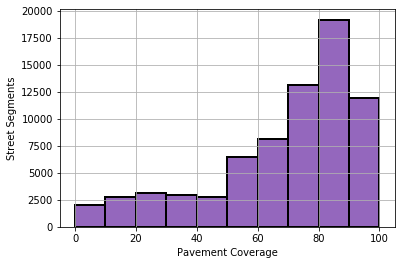

In [17]:
fig, ax = plt.subplots(1)
ax.set_xlabel("GDP (per capita)")

df_col_plt = pd.read_csv(fcolli_tims)
#df_col_plt.DAY_OF_WEEK.hist(bins=7,ax=ax,edgecolor='k',linewidth=2)
ax.set_xlabel('Pavement Coverage')
ax.set_ylabel('Street Segments')

l = [1.4,2.3,3.2,4.0,4.8,5.7,6.5]
d = ['M','T','W','Th','Fri','Sat','Sun']


#ax.set_xticks(l)
#ax.set_xticklabels(d)
df_pavcond_plt = pd.read_csv(fpavcond)
df_pavcond_plt.PCI.hist(ax=ax,edgecolor='k',linewidth=2,color='C4')

In [32]:
geo_df = gs.GeoDataFrame(df_pavcond, crs=crs, geometry='the_geom')
wkt.dumps(geo_df['the_geom'][0])

'MULTILINESTRING ((-118.2585764806535309 33.9637861883328682, -118.2585756249281985 33.9628797902877579))'

In [10]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [127]:
coords = [(-118.38, 34.0), (-118.38, 34.1), (-118.22, 34.1), (-118.22, 34.0)]
poly = Polygon(coords)
#poly_df = gs.GeoDataFrame(index=[0], crs=crs, geometry=[poly])
#bbox = poly_df.envelope
#df = gs.GeoDataFrame(gs.GeoSeries(bbox), columns=['geometry'])

In [150]:
def crop_pav(xy):
    x = xy[0][0]
    y = xy[1][0]
    p = Point(x,y)
    return p.within(poly)

keep = []
    
geom = geo_df.the_geom

print(geom[0].geoms)
for row in tqdm(geom):
    xy = row.geoms[0].coords.xy
    keep.append(crop_pav(xy))
#geo_df.apply(crop, axis=1,args=(geo_df.geometry,))

#x = geo_df.geometry[0].geoms[0].coords.xy[0][0]
#y = geo_df.geometry[0].geoms[0].coords.xy[1][0]
#p = Point(x,y)
#geo_df['keep'] = geo_df.apply(crop, axis=1)


  1%|          | 558/72562 [00:00<00:12, 5575.71it/s]

100%|██████████| 72562/72562 [00:14<00:00, 4957.70it/s]


In [156]:
geo_df['keep'] = keep
geo_df = geo_df[geo_df.keep] # Cropped it to a smaller area

In [163]:
def crop_col(x,y):
    p = Point(x,y)
    return p.within(poly)

inds = np.where(df_col['POINT_X'])

nbins = 50

xs = np.array(df_col['POINT_X'])[inds]
ys = np.array(df_col['POINT_Y'])[inds]

df_col = df_col.loc[inds]

ind2 = ~np.isnan(xs)
xs = xs[ind2]
ys = ys[ind2]
df_col = df_col.loc[ind2]

keep_col = []
for x,y in zip(df_col['POINT_X'],df_col['POINT_Y']):
    keep_col.append(crop_col(x,y))

df_col['keep'] = keep_col
df_col = df_col[df_col.keep]
    
xs = np.array(df_col['POINT_X'])
ys = np.array(df_col['POINT_Y'])
#k = kde.gaussian_kde([xs,ys])
#xi, yi = np.mgrid[xs.min():xs.max():nbins*1j, ys.min():ys.max():nbins*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))

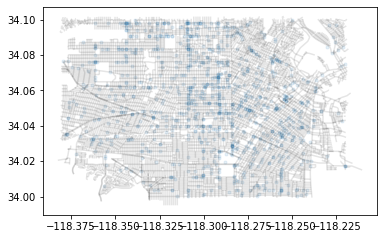

In [164]:
#plt.hist2d(xs, ys, bins=nbins, cmap=plt.cm.Oranges)
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Oranges)
#plt.contour(xi, yi, zi.reshape(xi.shape) )

fig, ax = plt.subplots(1)

geo_df.plot(figsize=(10, 10), alpha=0.1, edgecolor='k',ax=ax)
ax.scatter(xs,ys,marker='.',alpha=0.1)
#add_basemap(ax,zoom=1) #?? not sure how to use this

(-118.38, -118.22)

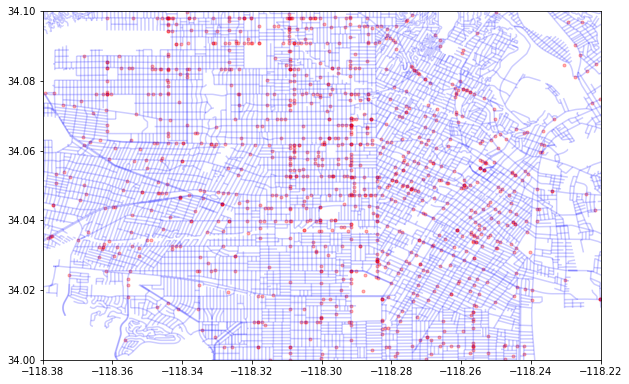

In [223]:
f, ax = plt.subplots(1,figsize=(10,10))
#for line in geo_df['the_geom']:
#    gs.plotting.plot_multilinestring(ax, line, linewidth=2, color='red')

ax.scatter(xs,ys,marker='.',alpha=0.3,color='r')
geo_df.plot(figsize=(10, 10), alpha=0.2, edgecolor='blue',ax=ax)

ax.set_ylim([34.0,34.1])
ax.set_xlim([-118.38,-118.22])
#Can dump whateva plots onto an interactive HTML!!!
#mplleaflet.show(path='hmm.html',fig=f)

In [220]:
#snippet from cycle-safe - might not work anyways
def find_nearest_seg(point, lines, thresh=20, return_dist=False):
    # Found a threshold of 20m based on looking at histogram:??
    # geocrash1.geometry.apply(lambda p,l: l.distance(p).min(), args=(bostonsegs,)).hist()
    dist = lines.distance(point)
    id = dist.idxmin()
    if return_dist:
        return id if dist[id] < thresh else np.nan,dist
    else:
        return id if dist[id] < thresh else np.nan

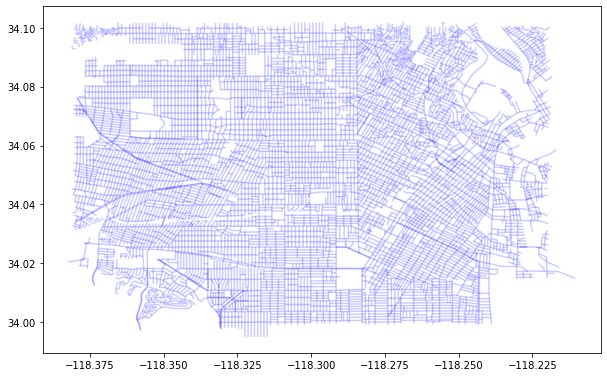

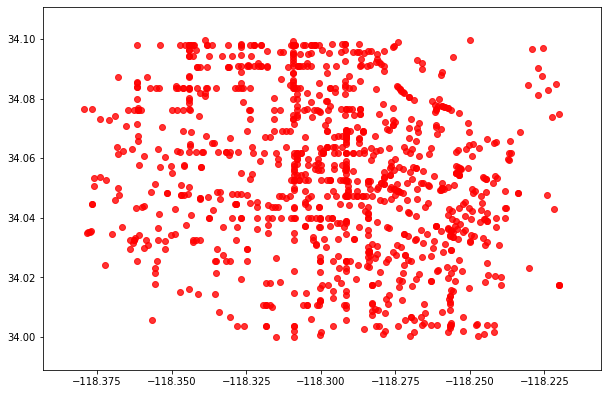

In [227]:
df_col['GEOMETRY'] = gs.points_from_xy(df_col.POINT_X, df_col.POINT_Y)
geo_col_df = gs.GeoDataFrame(df_col, crs=crs, geometry='GEOMETRY')
geo_df.plot(figsize=(10, 10), alpha=0.2, edgecolor='blue')
geo_col_df.plot(figsize=(10, 10), alpha=0.8,color='red')

In [170]:
geo_col_xy_df = geo_col_df.to_crs({'init': 'epsg:3857'})
geo_xy_df = geo_df.to_crs({'init': 'epsg:3857'})

#This will grab all of the indices of matched segments for each collision site
#geo_col_df['msegs'] = geo_col_xy_df.geometry.apply(find_nearest_seg, args=(geo_xy_df,50))


In [ ]:
#geo_col_df['msegs'] = geo_col_xy_df.geometry.apply(find_nearest_seg, args=(geo_xy_df,50))

In [240]:
acc_seg = []
for point in tqdm(geo_col_df.geometry):
    acc_seg.append(find_nearest_seg(point,geo_df,0.1))

100%|██████████| 1057/1057 [11:20<00:00,  1.66it/s]


In [461]:
reqtxt = 'http://router.project-osrm.org/route/v1/driving/-118.336389,34.100833;-118.356,34.0628?overview=simplified&exclude=motorway&annotations=true&geometries=geojson'
rout = requests.get(reqtxt)
route = json.loads(rout.text)

coords = [[-118.336131,34.100834],[-118.336124,34.099706],[-118.338707,34.099715],[-118.338636,34.064922],[-118.35465,34.06486],[-118.354608,34.063251],[-118.354932,34.062496],[-118.356007,34.062528]]

xs_route = [ c[0] for c in coords ]
ys_route = [ c[1] for c in coords ]

f, ax = plt.subplots(1)
#for line in geo_df['the_geom']:
#    gs.plot(line, color='yellow', linewidth=3,ax=ax)
#geo_col_df.plot(linewidth=3,ax=ax)
#ax.plot(xs_route,ys_route,color='blue',linewidth=4,alpha=0.)


ax.plot([-118.38,-118.22],[34.0,34.1],alpha=0)

geo_df.index = geo_df.index.map(str)

geo_df_pl = geo_df[geo_df.nacc != 0]

#geo_df_pl.the_geom.plot(alpha=0.9, edgecolor='red',ax=ax)

#geo_df_pl.to_file("test.geojson", driver='GeoJSON') # save to geojson

#geo_df_test = gs.read_file('test.geojson') #read from geojson


#geo_df_test.geometry.plot(alpha=0.9, edgecolor='red',ax=ax) #plot dangergrid

#mplleaflet.show(fig=f, crs=geo_df.crs,path='hmm.html')

mplleaflet.save_html(fig=f,fileobj='hmm2.html')

In [347]:
geo_col_df['accseg']=acc_seg
acc_counts = geo_col_df.groupby('accseg')['GEOMETRY'].count()

geo_df['nacc'] = 0

seg = acc_seg[0]

#geo_col_df
#geo_df.loc[57354]
for c,ind in enumerate(acc_counts.index):
    geo_df.at[ind,'nacc'] += int(acc_counts.iloc[c])

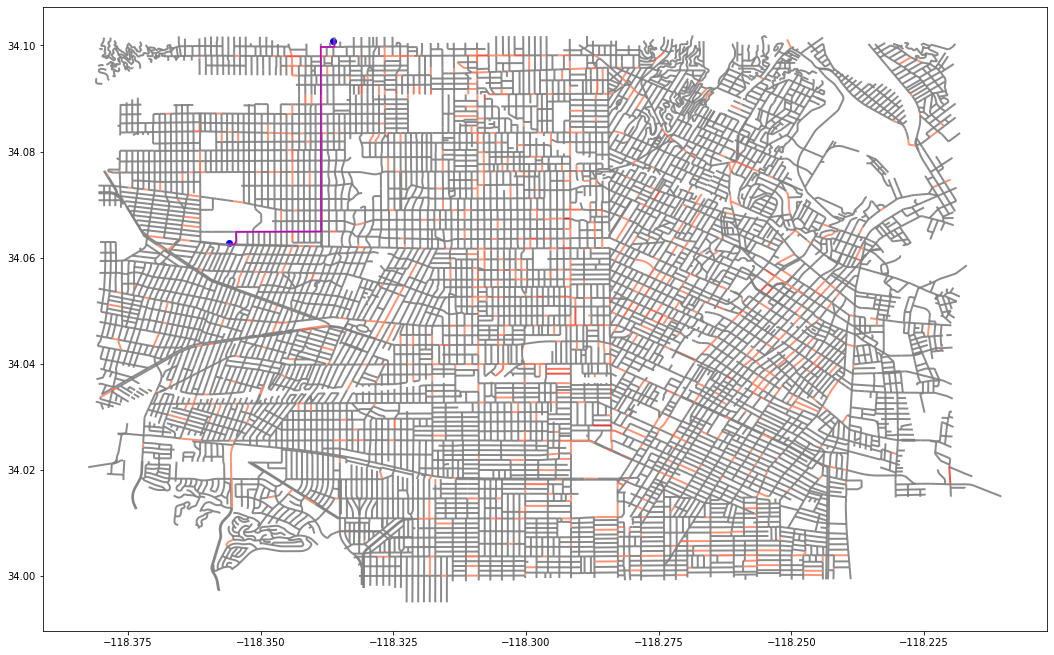

In [381]:
coords = [[-118.336131,34.100834],[-118.336124,34.099706],[-118.338707,34.099715],[-118.338636,34.064922],[-118.35465,34.06486],[-118.354608,34.063251],[-118.354932,34.062496],[-118.356007,34.062528]]

xs_route = [ c[0] for c in coords ]
ys_route = [ c[1] for c in coords ]

f, ax = plt.subplots(1,figsize=(18,18))

geo_df[['PCI','the_geom']].plot(alpha=0.9,linewidth=2, edgecolor=geo_df.nacc.apply(lambda x: rgba[x]),ax=ax)
ax.scatter(-118.336389,34.100833, color='blue',marker='o')
ax.scatter(-118.356,34.0628, color='blue',marker='o')

ax.plot(xs_route,ys_route,color='m')

In [404]:
def find_segs_within(geo_df,coords):
    
    start_coord = coords[0]
    for end_coord in coords[:-1]:
        dx = end_coord[0]-start_coord[0]
        dy = end_coord[1]-start_coord[0]
        start_coord = end_coord
        

find_segs_within(geo_df,coords)

ZeroDivisionError: float division by zero

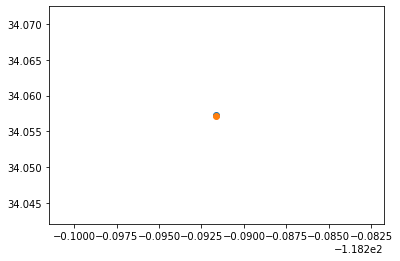

In [260]:
plt.scatter(geo_df.the_geom[57354].centroid.x,geo_df.the_geom[57354].centroid.y)


xss = [-118.5360835630244196, -118.5360844111095560, -118.5360850513779951, -118.5360852545307040]
yss = [34.2318630037923626, 34.2336768323800698, 34.2350447648330416, 34.2354907339569792]

#plt.scatter(geo_col_df.geometry.iloc[0].x,geo_col_df.geometry.iloc[0].y)
plt.scatter(-118.291652,34.057176)

In [465]:
geo_col_df.groupby('ROAD_COND_1').count()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y,keep,GEOMETRY,accseg
ROAD_COND_1,,,,,,,,,,,,,,,,,,,,,
-,10,10,10,10,10,10,10,10,10,10,...,10,0,0,10,10,10,10,10,10,10
A,8,8,8,8,8,8,8,8,8,8,...,8,0,0,8,8,8,8,8,8,8
B,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,1,1,1,1
C,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,1,1,1,1
D,4,4,4,4,4,4,4,4,4,4,...,4,0,0,4,4,4,4,4,4,4
E,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,1,1,1,1
F,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,1,1,1,1
G,3,3,3,3,3,3,3,3,3,3,...,3,0,0,3,3,3,3,3,3,3
H,1028,1028,1028,1028,1028,1028,1026,1009,1028,1028,...,1028,6,6,1028,1028,1028,1028,1028,1028,1028


In [5]:
swfile = '../data/raw/Sidewalks/Sidewalks.shp'
data = gs.read_file(swfile)

In [8]:
data

,OBJECTID,SIDEWALK_I,ASSETID,FEATURETYP,PIND,NOTES,CRTN_DT,LST_MODF_D,Shape__Are,Shape__Len,geometry
0,3001,1030022,3727454,Sidewalk,213B113-320,None,2017-01-10T22:49:14.000Z,2017-01-27T19:37:32.000Z,117.249023,44.614741,"POLYGON ((-118.569492026914 34.2802160005296, ..."
1,3002,1030023,3727455,Sidewalk,213B113-320,None,2017-01-10T23:17:16.000Z,2017-01-27T19:37:32.000Z,961.720703,482.064377,"POLYGON ((-118.568423649422 34.2805657970887, ..."
2,3003,1030024,3727456,Sidewalk,213B113-320,None,2017-01-10T23:17:16.000Z,2017-01-27T19:37:32.000Z,648.385742,332.251238,"POLYGON ((-118.568718621997 34.2807363167839, ..."
3,3004,1030025,3727457,Sidewalk,213B113-320,None,2017-01-10T23:17:16.000Z,2017-01-27T19:37:32.000Z,1641.531250,829.124433,"POLYGON ((-118.568708674451 34.2798978297097, ..."
4,3005,1030026,3727458,Sidewalk,216B117-139,None,2017-01-11T01:00:07.000Z,2017-01-11T01:00:43.000Z,799.420898,242.404234,"POLYGON ((-118.554287569862 34.287758943387, -..."
5,3006,1030027,3727459,Sidewalk,216B117-336,None,2017-01-11T01:03:21.000Z,2017-01-11T01:03:52.000Z,468.983398,200.520723,"POLYGON ((-118.554344088069 34.2850123722469, ..."
6,3007,1030028,3727460,Sidewalk,213B121-177,None,2017-01-11T01:15:46.000Z,2017-01-11T01:15:51.000Z,2907.407227,1173.199014,"POLYGON ((-118.545187704018 34.2799741463014, ..."
7,3008,1030029,3727461,Sidewalk,213B129-412,None,2017-01-11T19:17:08.000Z,2017-01-11T19:17:26.000Z,601.961914,241.922561,"POLYGON ((-118.516963304865 34.2832919535668, ..."
8,3009,1030030,3727462,Sidewalk,216B129-264,None,2017-01-11T19:20:43.000Z,2017-01-11T19:20:56.000Z,778.752930,321.665366,"POLYGON ((-118.5209208866 34.2872053643114, -1..."
9,3010,1030031,3727463,Sidewalk,216B129-175,None,2017-01-11T19:21:14.000Z,2017-01-11T19:21:14.000Z,741.077148,322.029055,"POLYGON ((-118.522323782787 34.2888505041009, ..."
